In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
# Set up the different data paths
ROOT = "c:/Users/summe/Git Repos/ml-agricultural-census-utah"
DATA_DIR = os.path.join(ROOT, "initial_analysis")
MODEL_EVAL_DIR = os.path.join(ROOT, "ml_model_finetuning")
MODEL_DIR = os.path.join(MODEL_EVAL_DIR, "models")
DATASET_PREDICT = os.path.join(DATA_DIR, "wheat_prod_unlabeled.csv")
DATASET_LABELED = os.path.join(DATA_DIR, "wheat_prod_labeled.csv")
XGB_MODEL = os.path.join(MODEL_DIR, "agricultural_census_model_xgb.pkl")

# Show the current paths 
print("ROOT: ", ROOT)
print("DATA_DIR: ", DATA_DIR)
print("DATASET_PREDICT: ", DATASET_PREDICT)
print("DATASET_LABELED: ", DATASET_LABELED)
print("MODEL_DIR: ", MODEL_DIR)
print("XGB_MODEL: ", XGB_MODEL)

ROOT:  c:/Users/summe/Git Repos/ml-agricultural-census-utah
DATA_DIR:  c:/Users/summe/Git Repos/ml-agricultural-census-utah\initial_analysis
DATASET_PREDICT:  c:/Users/summe/Git Repos/ml-agricultural-census-utah\initial_analysis\wheat_prod_unlabeled.csv
DATASET_LABELED:  c:/Users/summe/Git Repos/ml-agricultural-census-utah\initial_analysis\wheat_prod_labeled.csv
MODEL_DIR:  c:/Users/summe/Git Repos/ml-agricultural-census-utah\ml_model_finetuning\models
XGB_MODEL:  c:/Users/summe/Git Repos/ml-agricultural-census-utah\ml_model_finetuning\models\agricultural_census_model_xgb.pkl


In [11]:
# Load the labeled dataset
df = pd.read_csv(DATASET_LABELED)
df

,year,county,countyansi,wheatprod,pop,wheatprice,wheatprice_l1,wheatprice_l2,precipitation,maximum_temperature,...,county23,county24,county25,county26,county27,year1,year2,year3,year4,year5
0,2012,beaver,1,53666,6500,9.59,8.26,7.43,11.540000,65.400002,...,0,0,0,0,0,0,0,1,0,0
1,2002,box elder,3,1921384,44038,4.65,3.30,3.25,9.290000,60.099998,...,0,0,0,0,0,1,0,0,0,0
2,2007,box elder,3,2879583,47193,8.30,4.85,3.80,8.830000,62.599998,...,0,0,0,0,0,0,1,0,0,0
3,2012,box elder,3,2798821,50205,9.59,8.26,7.43,9.250000,63.400002,...,0,0,0,0,0,0,0,1,0,0
4,2017,box elder,3,2713277,53999,5.20,4.30,5.18,13.170000,61.099998,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2002,weber,57,98023,203045,4.65,3.30,3.25,20.709999,56.900002,...,0,0,0,0,1,1,0,0,0,0
66,2007,weber,57,166724,217567,8.30,4.85,3.80,21.930000,59.299999,...,0,0,0,0,1,0,1,0,0,0
67,2012,weber,57,255650,236268,9.59,8.26,7.43,21.440001,60.200001,...,0,0,0,0,1,0,0,1,0,0
68,2017,weber,57,98200,251474,5.20,4.30,5.18,32.060001,59.299999,...,0,0,0,0,1,0,0,0,1,0


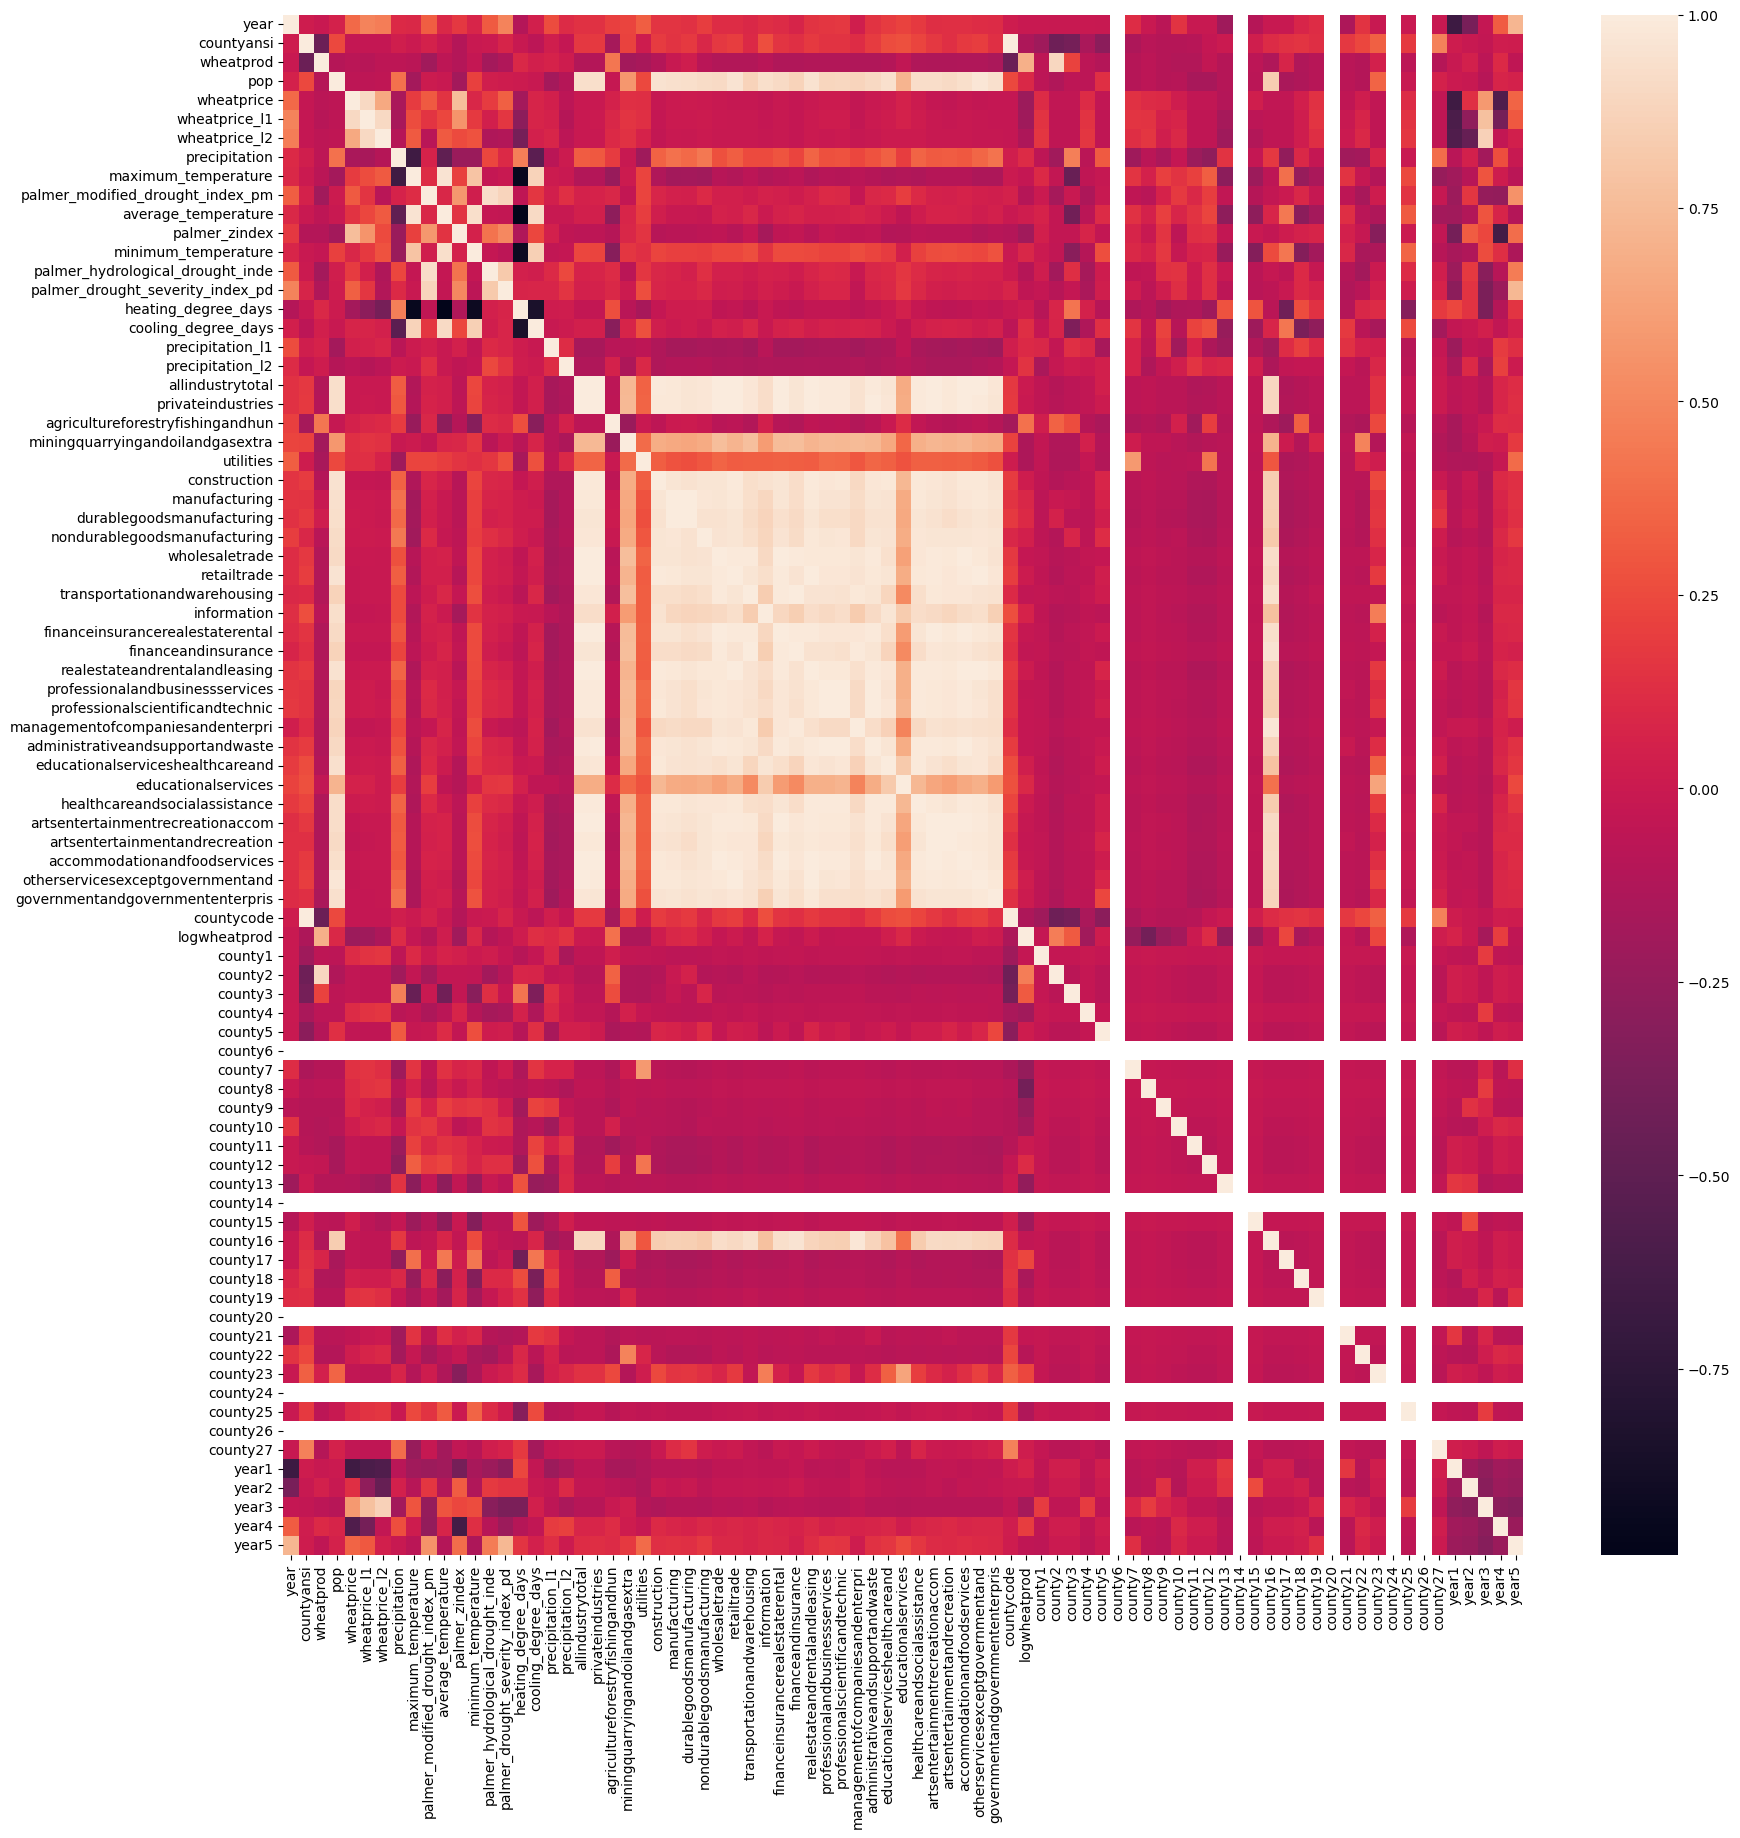

In [12]:
# create correlation matrix
df = df.drop(columns='county')
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr)
plt.show()

In [25]:
# get the top 5 most correlated features and the top 5 least correlated features
wheatprod_corr = corr['wheatprod'].sort_values(ascending=False)
# get rid of all the names that start with county and year
wheatprod_corr = wheatprod_corr[~wheatprod_corr.index.str.contains('county')]
wheatprod_corr = wheatprod_corr[~wheatprod_corr.index.str.contains('year')]
wheatprod_corr = wheatprod_corr[~wheatprod_corr.index.str.contains('wheatprod')]
print("Top 5 most correlated features: \n", wheatprod_corr.head(5))
print("Top 5 least correlated features: \n", wheatprod_corr.tail(5))

Top 5 most correlated features: 
 agricultureforestryfishingandhun    0.428926
heating_degree_days                 0.091217
precipitation_l1                    0.064762
cooling_degree_days                 0.039098
durablegoodsmanufacturing           0.023481
Name: wheatprod, dtype: float64
Top 5 least correlated features: 
 governmentandgovernmententerpris   -0.145094
utilities                          -0.165912
palmer_hydrological_drought_inde   -0.175641
miningquarryingandoilandgasextra   -0.184620
palmer_modified_drought_index_pm   -0.191327
Name: wheatprod, dtype: float64


In [27]:
important_features = list(wheatprod_corr.head(5).index) + list(wheatprod_corr.tail(5).index)
important_features

['agricultureforestryfishingandhun',
 'heating_degree_days',
 'precipitation_l1',
 'cooling_degree_days',
 'durablegoodsmanufacturing',
 'governmentandgovernmententerpris',
 'utilities',
 'palmer_hydrological_drought_inde',
 'miningquarryingandoilandgasextra',
 'palmer_modified_drought_index_pm']

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import pickle

In [41]:
X = df[important_features]
y = df['wheatprod']



In [42]:
# scale the X variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# create a dictionary of models
models = {
    'OLS': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Elastic Net': ElasticNet(),
    'XGBoost': xgb.XGBRegressor(),
    'Random Forest': RandomForestRegressor(),
    'GBR': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'MLP': MLPRegressor()
}

# create a dictionary to store the results
results = {}

# loop through the models
loop = tqdm(models.items(), total=len(models), colour='red')
# get the metrics for each model on both the training and testing sets
for name, model in loop:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    results[name] = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }
    loop.set_description(f"Processing {name}")
    loop.refresh()
loop.close()

# create a DataFrame from the results dictionary
results_df = pd.DataFrame(results).T
results_df

Processing Decision Tree:  69%|██████▉   | 9/13 [00:00<00:00, 13.79it/s]c:\Users\summe\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Processing MLP: 100%|██████████| 13/13 [00:00<00:00, 19.34it/s]         


,Train MAE,Test MAE,Train R2,Test R2
OLS,336504.896981,264581.724023,0.520890,0.507026
Lasso,336502.944810,264581.933417,0.520890,0.507022
Ridge,326209.101360,269479.394209,0.513446,0.446912
Elastic Net,349219.466584,326777.963724,0.350023,0.153830
XGBoost,0.051579,581194.908334,1.000000,-2.624456
Random Forest,121585.964464,466305.848571,0.914085,-0.954906
GBR,6257.032860,394795.325735,0.999870,-0.803852
AdaBoost,100821.304724,332181.039529,0.967847,0.002347
Bagging,134201.696429,530380.407143,0.848735,-1.768121
SVR,354397.812951,250212.741269,-0.181539,-0.102593


In [43]:
# cross validate the models
cv_results = {}
loop = tqdm(models.items(), total=len(models), colour='red')
for name, model in loop:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
    cv_results[name] = scores*-1
    loop.set_description(f"Processing {name}")
    loop.refresh()
loop.close()

#average out the cross validation results
for key in cv_results:
    cv_results[key] = cv_results[key].mean()

# create a DataFrame from the cross validation results
cv_results_df = pd.DataFrame(cv_results, index=[0])
cv_results_df



Processing Decision Tree:  77%|███████▋  | 10/13 [00:02<00:00,  3.67it/s]c:\Users\summe\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\summe\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\summe\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\summe\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't

,OLS,Lasso,Ridge,Elastic Net,XGBoost,Random Forest,GBR,AdaBoost,Bagging,SVR,KNN,Decision Tree,MLP
0,599843.060833,599839.483458,525419.615036,457499.00173,548660.681616,508293.987286,581703.000219,487777.669871,500789.512857,339701.793746,494789.025714,721019.0,370358.844065


In [44]:
#show the best model
cv_results_df.idxmin(axis=1)


0    SVR
dtype: object

In [45]:
#cross validated best model is SVR
#fit the model
# fine tune the model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3, cv=5)
grid.fit(X_scaled, y)

# show the best parameters
grid.best_params_



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-1.256 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-1.951 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.068 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.159 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.354 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=1, kernel=poly;, score=-1.250 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=1, kernel=poly;, score=-2.138 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=1, kernel=poly;, score=-0.070 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=1, kernel=poly;, score=-0.159 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=1, kernel=poly;, score=-0.344 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=1, kernel=sigmoid;, score=-1.256 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=1, kernel=sigmoid;

{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}

In [46]:
# create the model with the best parameters
model = SVR(C=100, gamma=0.01, kernel='rbf')
model.fit(X_scaled, y)

# show final metrics

y_pred = model.predict(X_scaled)
print("Final MAE: ", mean_absolute_error(y, y_pred))
print("Final R2: ", r2_score(y, y_pred))


Final MAE:  333400.5728404703
Final R2:  -0.17330236100340746


In [47]:
# save the model 
with open('models/webapp_model.pkl', 'wb') as f:
    pickle.dump(model, f)